### Video Classification using Transformer

In [441]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp 

import torch 
import torch.nn as nn
import torch.nn.functional as F

In [442]:
mp_holist = mp.solutions.holistic 
mp_draw = mp.solutions.drawing_utils

In [443]:
def mediapipe_detection(img, model):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img.flags.writeable = False                 
    result = model.process(img)                 # Make prediction
    img.flags.writeable = True                   
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
    return img, result

In [444]:
def draw_landmarks(img, result):
    mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS) # Draw face connections
    mp_draw.draw_landmarks(img, result.pose_landmarks, mp_holist.POSE_CONNECTIONS) # Draw pose connections
    mp_draw.draw_landmarks(img, result.left_hand_landmarks, mp_holist.HAND_CONNECTIONS) # Draw left hand connections
    mp_draw.draw_landmarks(img, result.right_hand_landmarks, mp_holist.HAND_CONNECTIONS) # Draw right hand connections

In [445]:
def draw_styled_landmarks(img, result):
    mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS, 
                             mp_draw.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color the joint 
                             mp_draw.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #color the connection
                             ) 
    # mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS, 
    #                          mp_draw.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color the joint 
    #                          mp_draw.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #color the connection
    #                          ) 
    
    mp_draw.draw_landmarks(img, result.pose_landmarks, mp_holist.POSE_CONNECTIONS,
                             mp_draw.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(img, result.left_hand_landmarks, mp_holist.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(img, result.right_hand_landmarks, mp_holist.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [446]:
def extract_keypoints(results):
    pose=np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    left_hnd=np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hnd=np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face=np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    return np.concatenate([pose,left_hnd,right_hnd,face])
# concatenating for the model to detect the sign language

In [447]:
import os 
video_dir = "C:/Users/araya/Desktop/keypoints/video_extract"
video_list = []
video_list = os.listdir(video_dir)

len(video_list)

40

In [448]:
# # For Training Only
# import os 
# video_dir = "C:/Users/araya/Desktop/vscode/Deep-learning-coding/MediaPipe/Data for different actions"
# video_list = []
# video_list = os.listdir(video_dir)

# len(video_list)

In [449]:
video_list

['กฎกระทรวง.mp4',
 'กฎหมายรัฐธรรมนูญ.mp4',
 'กรมอนามัย.mp4',
 'กรรม.mp4',
 'กรรมสิทธิ์.mp4',
 'กระโดด.mp4',
 'กล้วยบวชชี.mp4',
 'กล้วยเชื่อม.mp4',
 'กังวล.mp4',
 'กีฬา.mp4',
 'น้อง.mp4',
 'เขิน.mp4',
 'เขื่อนดิน.mp4',
 'เขื่อนสิริกิติ์.mp4',
 'เข้าใจผิด.mp4',
 'เคย.mp4',
 'เครียด.mp4',
 'เครื่องปั่นดิน.mp4',
 'เครื่องหมายการค้า.mp4',
 'เจอ.mp4',
 'เจ้าหนี้.mp4',
 'เช่าซื้อ.mp4',
 'เช่าทรัพย์.mp4',
 'เซอร์เบีย.mp4',
 'เซเนกัล.mp4',
 'เซ็ง.mp4',
 'เดิน.mp4',
 'เดิมพัน.mp4',
 'เพลีย.mp4',
 'เมื่อย.mp4',
 'เม็กซิโก.mp4',
 'เฮโรอีน.mp4',
 'แกมเบีย.mp4',
 'แซมเบีย.mp4',
 'โกหก.mp4',
 'โจทก์.mp4',
 'โชจู.mp4',
 'ใกล้.mp4',
 'ไดโนเสาร์.mp4',
 'ไอซ์.mp4']

In [450]:
# Path for exported data, numpy arrays
Model_Data=os.path.join('Data for different actions')

actions = np.array(video_list)

no_of_seqs = 1

# 30 frames in length
seq_length = 160

In [451]:
actions

array(['กฎกระทรวง.mp4', 'กฎหมายรัฐธรรมนูญ.mp4', 'กรมอนามัย.mp4',
       'กรรม.mp4', 'กรรมสิทธิ์.mp4', 'กระโดด.mp4', 'กล้วยบวชชี.mp4',
       'กล้วยเชื่อม.mp4', 'กังวล.mp4', 'กีฬา.mp4', 'น้อง.mp4', 'เขิน.mp4',
       'เขื่อนดิน.mp4', 'เขื่อนสิริกิติ์.mp4', 'เข้าใจผิด.mp4', 'เคย.mp4',
       'เครียด.mp4', 'เครื่องปั่นดิน.mp4', 'เครื่องหมายการค้า.mp4',
       'เจอ.mp4', 'เจ้าหนี้.mp4', 'เช่าซื้อ.mp4', 'เช่าทรัพย์.mp4',
       'เซอร์เบีย.mp4', 'เซเนกัล.mp4', 'เซ็ง.mp4', 'เดิน.mp4',
       'เดิมพัน.mp4', 'เพลีย.mp4', 'เมื่อย.mp4', 'เม็กซิโก.mp4',
       'เฮโรอีน.mp4', 'แกมเบีย.mp4', 'แซมเบีย.mp4', 'โกหก.mp4',
       'โจทก์.mp4', 'โชจู.mp4', 'ใกล้.mp4', 'ไดโนเสาร์.mp4', 'ไอซ์.mp4'],
      dtype='<U21')

Collecting keypoint values for Training nd Testing

In [452]:
# Define the directory where your videos are stored
directory = "C:/Users/araya/Desktop/keypoints/video_extract"

In [453]:
# # For Training Only
# directory = "C:/Users/araya/Desktop/vscode/Deep-learning-coding/MediaPipe/Data for different actions"

In [454]:
directory

'C:/Users/araya/Desktop/keypoints/video_extract'

In [455]:
for filename in actions:
    print(directory + '/' + filename)

C:/Users/araya/Desktop/keypoints/video_extract/กฎกระทรวง.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กฎหมายรัฐธรรมนูญ.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กรมอนามัย.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กรรม.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กรรมสิทธิ์.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กระโดด.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กล้วยบวชชี.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กล้วยเชื่อม.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กังวล.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กีฬา.mp4
C:/Users/araya/Desktop/keypoints/video_extract/น้อง.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เขิน.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เขื่อนดิน.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เขื่อนสิริกิติ์.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เข้าใจผิด.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เคย.mp4
C:/Users/araya/Desktop/keypoints/video_e

In [456]:
file_paths = []
for action in actions:
    video_path = os.path.join('Data for different actions/', action)
    # print(video_path)
    # print(action)
    file_paths.append(video_path + '/' + action.split(".")[0] + ".npy")
print(file_paths)

['Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy', 'Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy', 'Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy', 'Data for different actions/กรรม.mp4/กรรม.npy', 'Data for different actions/กรรมสิทธิ์.mp4/กรรมสิทธิ์.npy', 'Data for different actions/กระโดด.mp4/กระโดด.npy', 'Data for different actions/กล้วยบวชชี.mp4/กล้วยบวชชี.npy', 'Data for different actions/กล้วยเชื่อม.mp4/กล้วยเชื่อม.npy', 'Data for different actions/กังวล.mp4/กังวล.npy', 'Data for different actions/กีฬา.mp4/กีฬา.npy', 'Data for different actions/น้อง.mp4/น้อง.npy', 'Data for different actions/เขิน.mp4/เขิน.npy', 'Data for different actions/เขื่อนดิน.mp4/เขื่อนดิน.npy', 'Data for different actions/เขื่อนสิริกิติ์.mp4/เขื่อนสิริกิติ์.npy', 'Data for different actions/เข้าใจผิด.mp4/เข้าใจผิด.npy', 'Data for different actions/เคย.mp4/เคย.npy', 'Data for different actions/เครียด.mp4/เครียด.npy', 'Data for different actions/เครื่องปั่นดิน.mp4/เครื

In [457]:
def load_keypoint_sequences(file_paths):
    keypoint_sequences = []
    for file_path in file_paths:
        print(file_path)
        keypoints = np.load(file_path)
        keypoint_sequences.append(torch.tensor(keypoints, dtype=torch.float32))
    return keypoint_sequences

In [458]:
# Load the sequences
import torch
sequences = load_keypoint_sequences(file_paths)
sequences

Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy
Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy
Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy
Data for different actions/กรรม.mp4/กรรม.npy
Data for different actions/กรรมสิทธิ์.mp4/กรรมสิทธิ์.npy
Data for different actions/กระโดด.mp4/กระโดด.npy
Data for different actions/กล้วยบวชชี.mp4/กล้วยบวชชี.npy
Data for different actions/กล้วยเชื่อม.mp4/กล้วยเชื่อม.npy
Data for different actions/กังวล.mp4/กังวล.npy
Data for different actions/กีฬา.mp4/กีฬา.npy
Data for different actions/น้อง.mp4/น้อง.npy
Data for different actions/เขิน.mp4/เขิน.npy
Data for different actions/เขื่อนดิน.mp4/เขื่อนดิน.npy
Data for different actions/เขื่อนสิริกิติ์.mp4/เขื่อนสิริกิติ์.npy
Data for different actions/เข้าใจผิด.mp4/เข้าใจผิด.npy
Data for different actions/เคย.mp4/เคย.npy
Data for different actions/เครียด.mp4/เครียด.npy
Data for different actions/เครื่องปั่นดิน.mp4/เครื่องปั่นดิน.npy
Data for different actions/เครื่องหมาย

[tensor([[ 0.5013,  0.2452, -1.2167,  ...,  0.5663,  0.2188,  0.0098],
         [ 0.4997,  0.2482, -1.4690,  ...,  0.5652,  0.2181,  0.0106],
         [ 0.4984,  0.2500, -1.4853,  ...,  0.5654,  0.2185,  0.0112],
         ...,
         [ 0.4861,  0.2513, -1.3416,  ...,  0.5572,  0.2177,  0.0091],
         [ 0.4873,  0.2514, -1.3574,  ...,  0.5575,  0.2172,  0.0097],
         [ 0.4883,  0.2516, -1.3579,  ...,  0.5577,  0.2170,  0.0101]]),
 tensor([[ 0.4922,  0.2382, -1.2850,  ...,  0.5578,  0.2124,  0.0094],
         [ 0.4920,  0.2405, -1.4288,  ...,  0.5571,  0.2116,  0.0099],
         [ 0.4920,  0.2409, -1.4093,  ...,  0.5567,  0.2122,  0.0098],
         ...,
         [ 0.4814,  0.2260, -1.3318,  ...,  0.5503,  0.1923,  0.0123],
         [ 0.4815,  0.2257, -1.3351,  ...,  0.5503,  0.1921,  0.0122],
         [ 0.4815,  0.2255, -1.3497,  ...,  0.5501,  0.1919,  0.0124]]),
 tensor([[ 0.5049,  0.2371, -1.2115,  ...,  0.5643,  0.2082,  0.0088],
         [ 0.5045,  0.2381, -1.1896,  ...,  0

In [459]:
print(type(sequences))
print(sequences[0].shape)
print(sequences[1].shape)
print(sequences[2].shape)
print(sequences[3].shape)
print(sequences[4].shape)
print("We can see that each row (lenght of video) is not the same size, so we need to pad them.")

<class 'list'>
torch.Size([142, 1662])
torch.Size([134, 1662])
torch.Size([151, 1662])
torch.Size([100, 1662])
torch.Size([160, 1662])
We can see that each row (lenght of video) is not the same size, so we need to pad them.


In [460]:
# Pad the sequences to the same length
from torch.nn.utils.rnn import pad_sequence
padded_sequences = pad_sequence(sequences, batch_first=True)
print(padded_sequences.shape) # (batch_size, max_sequence_length, num_keypoints)

torch.Size([40, 160, 1662])


In [461]:
print(type(padded_sequences))
print(padded_sequences[0].shape)
print(padded_sequences[1].shape)
print(padded_sequences[2].shape)
print(padded_sequences[3].shape)
print(padded_sequences[4].shape)

<class 'torch.Tensor'>
torch.Size([160, 1662])
torch.Size([160, 1662])
torch.Size([160, 1662])
torch.Size([160, 1662])
torch.Size([160, 1662])


In [462]:
sequences[2] 

tensor([[ 0.5049,  0.2371, -1.2115,  ...,  0.5643,  0.2082,  0.0088],
        [ 0.5045,  0.2381, -1.1896,  ...,  0.5643,  0.2081,  0.0085],
        [ 0.5041,  0.2385, -1.1915,  ...,  0.5643,  0.2080,  0.0089],
        ...,
        [ 0.4963,  0.2307, -1.3096,  ...,  0.5624,  0.2043,  0.0127],
        [ 0.4965,  0.2308, -1.3085,  ...,  0.5625,  0.2045,  0.0126],
        [ 0.4972,  0.2312, -1.3053,  ...,  0.5633,  0.2045,  0.0128]])

In [463]:
labels = [action.split(".")[0] for action in actions]
labels

['กฎกระทรวง',
 'กฎหมายรัฐธรรมนูญ',
 'กรมอนามัย',
 'กรรม',
 'กรรมสิทธิ์',
 'กระโดด',
 'กล้วยบวชชี',
 'กล้วยเชื่อม',
 'กังวล',
 'กีฬา',
 'น้อง',
 'เขิน',
 'เขื่อนดิน',
 'เขื่อนสิริกิติ์',
 'เข้าใจผิด',
 'เคย',
 'เครียด',
 'เครื่องปั่นดิน',
 'เครื่องหมายการค้า',
 'เจอ',
 'เจ้าหนี้',
 'เช่าซื้อ',
 'เช่าทรัพย์',
 'เซอร์เบีย',
 'เซเนกัล',
 'เซ็ง',
 'เดิน',
 'เดิมพัน',
 'เพลีย',
 'เมื่อย',
 'เม็กซิโก',
 'เฮโรอีน',
 'แกมเบีย',
 'แซมเบีย',
 'โกหก',
 'โจทก์',
 'โชจู',
 'ใกล้',
 'ไดโนเสาร์',
 'ไอซ์']

In [464]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

labels = le.fit_transform(labels)
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39], dtype=int64)

### For Training Only

In [465]:
# import pandas as pd
# df = pd.read_csv("script1.csv")

In [466]:
# labels = []

# for i in range(len(df.label)):
#     labels.append(df.label[i])

In [467]:
# labels

In [468]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Create a custom dataset
class KeypointDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        keypoints = np.load(self.file_paths[idx])
        label = self.labels[idx]
        return torch.tensor(keypoints, dtype=torch.float32), label

In [469]:
# Create the dataset
dataset = KeypointDataset(file_paths, labels)

In [470]:
dataset

In [471]:
print(dataset.file_paths)
print(dataset.labels)

['Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy', 'Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy', 'Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy', 'Data for different actions/กรรม.mp4/กรรม.npy', 'Data for different actions/กรรมสิทธิ์.mp4/กรรมสิทธิ์.npy', 'Data for different actions/กระโดด.mp4/กระโดด.npy', 'Data for different actions/กล้วยบวชชี.mp4/กล้วยบวชชี.npy', 'Data for different actions/กล้วยเชื่อม.mp4/กล้วยเชื่อม.npy', 'Data for different actions/กังวล.mp4/กังวล.npy', 'Data for different actions/กีฬา.mp4/กีฬา.npy', 'Data for different actions/น้อง.mp4/น้อง.npy', 'Data for different actions/เขิน.mp4/เขิน.npy', 'Data for different actions/เขื่อนดิน.mp4/เขื่อนดิน.npy', 'Data for different actions/เขื่อนสิริกิติ์.mp4/เขื่อนสิริกิติ์.npy', 'Data for different actions/เข้าใจผิด.mp4/เข้าใจผิด.npy', 'Data for different actions/เคย.mp4/เคย.npy', 'Data for different actions/เครียด.mp4/เครียด.npy', 'Data for different actions/เครื่องปั่นดิน.mp4/เครื

In [472]:
# Collate function for padding
def collate_fn(batch):
    sequences, labels = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True)
    return padded_sequences, torch.tensor(labels)

In [473]:
# Create the DataLoader
batch_size = 4
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
data_loader

In [474]:
# Set device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Transformer

In [475]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.metrics import f1_score

# class AttentionLayer(nn.Module):
#     def __init__(self, hidden_size):
#         super(AttentionLayer, self).__init__()
#         self.attention_weights = nn.Linear(hidden_size, 1, bias=False)

#     def forward(self, lstm_output):
#         # lstm_output: (batch_size, sequence_length, hidden_size)
#         attention_scores = self.attention_weights(lstm_output)  # (batch_size, sequence_length, 1)
#         attention_weights = torch.softmax(attention_scores, dim=1)  # (batch_size, sequence_length, 1)
#         weighted_output = torch.sum(lstm_output * attention_weights, dim=1)  # (batch_size, hidden_size)
#         return weighted_output, attention_weights

In [476]:
# class Encoder(nn.Module):
#     def __init__(self, input_size, num_heads, dropout):
#         super().__init__()
#         self.multihead = nn.MultiheadAttention(embed_dim=input_size, num_heads=num_heads)
#         self.normalize_layer = nn.LayerNorm(normalized_shape=input_size, eps=1e-5)
#         self.fc1 = nn.Linear(input_size, input_size)
#         self.pool = nn.MaxPool2d(kernel_size=(2,1), stride=1)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x):
#         attn_output, attn_output_weights = self.multihead(x, x, x)

#         normalize_attn = self.normalize_layer(x+attn_output)

#         final_output = self.normalize_layer(self.fc1(normalize_attn)+normalize_attn)

#         final_output = self.pool(final_output)

#         return final_output

In [477]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

class Encoder(nn.Module):
    def __init__(self, input_size, num_heads, dropout, num_classes):
        super(Encoder, self).__init__()
        self.multihead = nn.MultiheadAttention(embed_dim=input_size, num_heads=num_heads)
        self.normalize_layer = nn.LayerNorm(normalized_shape=input_size, eps=1e-5)
        self.fc1 = nn.Linear(input_size, input_size)
        self.fc2 = nn.Linear(input_size, num_classes)  # Output layer for classification
        self.pool = nn.MaxPool1d(kernel_size=2, stride=1)  # Changed to MaxPool1d
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x should have shape [sequence_length, batch_size, input_size] for MultiheadAttention
        attn_output, _ = self.multihead(x, x, x)  # Self-attention

        normalize_attn = self.normalize_layer(x + attn_output)  # Add & Norm
        final_output = self.normalize_layer(self.fc1(normalize_attn) + normalize_attn)  # Another Add & Norm

        # Assuming you're pooling over the sequence length (dimension 0)
        pooled_output = self.pool(final_output.permute(1, 2, 0))  # Pooling across sequence length

        pooled_output = pooled_output.permute(2, 0, 1)  # Permute back to [sequence_length, batch_size, input_size]
        pooled_output = pooled_output[-1]  # Take the last time step for classification

        output = self.fc2(pooled_output)  # Final classification layer

        return output

In [478]:
# Initialize the model, loss function, and optimizer
model = Encoder(input_size=1662, num_heads=6, dropout=0.5, num_classes=40).to(device)

In [479]:
model

Encoder(
  (multihead): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1662, out_features=1662, bias=True)
  )
  (normalize_layer): LayerNorm((1662,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=1662, out_features=1662, bias=True)
  (fc2): Linear(in_features=1662, out_features=40, bias=True)
  (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [480]:
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [481]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 13889374 (Approximately 13 Million) Parameters!


In [482]:
data_loader.dataset.labels[2]

2

In [483]:
# #Load model
# model.load_state_dict(torch.load('saved_data/transformer_model.pt'))
# optimizer.load_state_dict(torch.load('saved_data/transformer_optimizer.pt'))

In [484]:
#Load model
model.load_state_dict(torch.load('200epoch_transformer_model.pt'))
optimizer.load_state_dict(torch.load('200epoch_transformer_optimizer.pt'))

In [ ]:
# Training loop
# References : https://saturncloud.io/blog/calculating-the-accuracy-of-pytorch-models-every-epoch/#:~:text=In%20order%20to%20calculate%20the,tensor%20along%20a%20specified%20dimension

from sklearn.metrics import f1_score, recall_score

num_epochs = 300
loss_logger = []
accuracy_logger = []
# n_epochs = []

f1_logger = []
recall_logger = []

all_preds = []
all_labels = []

for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    model.train()
    for i, (sequences, labels) in enumerate(data_loader):
        # Move data to the device
        # labels = labels.type(torch.LongTensor)   # casting to long
        sequences = sequences.to(device)
        sequences = sequences.permute(1, 0, 2)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(sequences)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Store predictions and labels for calculating metrics
        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())    # Store true labels
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss_logger.append(loss.item())
    loss_logger.append(loss.item())
    accuracy = 100 * total_correct /total_samples

    # Calculate F1 score and recall
    f1 = f1_score(all_labels, all_preds, average='weighted')  # Weighted average for multi-class
    recall = recall_score(all_labels, all_preds, average='weighted')

    f1_logger.append(f1)
    recall_logger.append(recall)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f} , Accuracy : {accuracy:.2f}%, F1 Score: {f1:.2f}, Recall: {recall:.2f}')
    accuracy_logger.append(accuracy)
    # n_epochs.append(epoch)

In [509]:
loss_logger

[4.796689987182617,
 3.3591010570526123,
 3.594700813293457,
 3.9908134937286377,
 3.2662837505340576,
 2.9342706203460693,
 2.840343475341797,
 2.7082977294921875,
 3.83354115486145,
 2.930375576019287,
 2.836240291595459,
 3.0702457427978516,
 2.896364688873291,
 2.379570722579956,
 1.020846962928772,
 1.8040467500686646,
 1.3563594818115234,
 0.5812689661979675,
 0.9965157508850098,
 1.4804625511169434,
 1.6551332473754883,
 0.8525649309158325,
 2.052044153213501,
 1.017073154449463,
 2.3555197715759277,
 1.1976813077926636,
 0.6416618824005127,
 0.3749921917915344,
 1.5568737983703613,
 0.413657009601593,
 0.5901164412498474,
 0.8183141350746155,
 0.4550849497318268,
 0.9205434322357178,
 0.3510637879371643,
 0.721139669418335,
 0.9399386644363403,
 0.4268527328968048,
 0.2754508852958679,
 0.6763890981674194,
 1.3863991498947144,
 0.5498056411743164,
 0.5296581387519836,
 0.3494955599308014,
 0.8737124800682068,
 1.2603673934936523,
 1.06465482711792,
 0.8889890909194946,
 0.57512

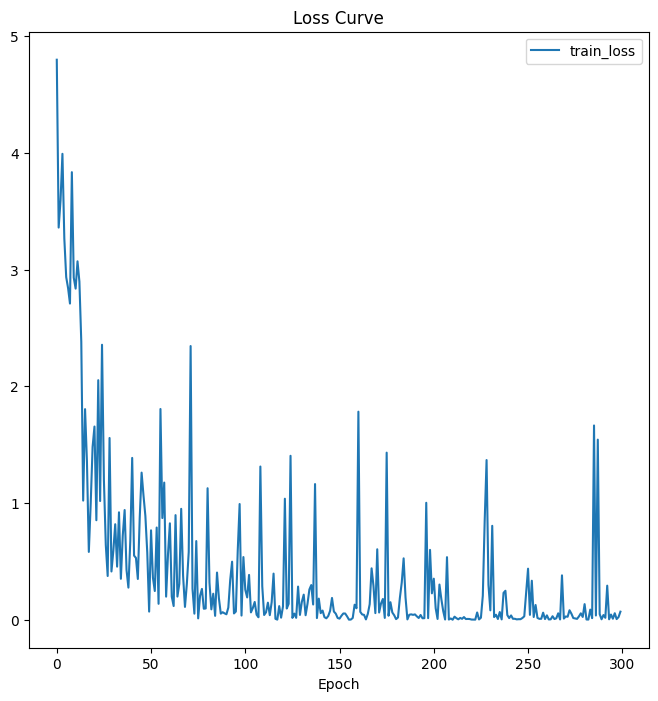

In [510]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
plt.title("Loss Curve")
plt.plot(loss_logger, label='train_loss')
# plt.plot(accuracy_logger,label='accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

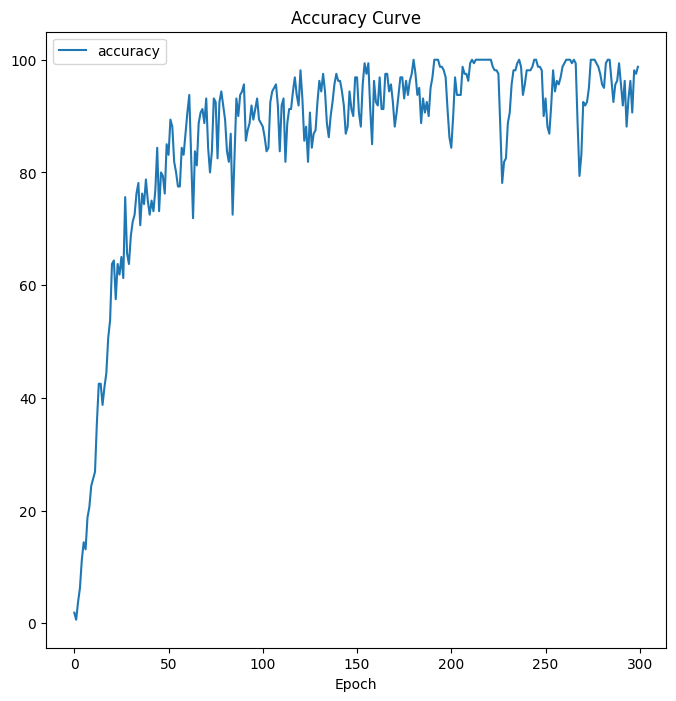

In [511]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
plt.title("Accuracy Curve")
# plt.plot(loss_logger, label='train_loss')
plt.plot(accuracy_logger,label='accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Save and Load Model

In [485]:
pad_sequence(sequences, batch_first=True)

tensor([[[ 0.5013,  0.2452, -1.2167,  ...,  0.5663,  0.2188,  0.0098],
         [ 0.4997,  0.2482, -1.4690,  ...,  0.5652,  0.2181,  0.0106],
         [ 0.4984,  0.2500, -1.4853,  ...,  0.5654,  0.2185,  0.0112],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.4922,  0.2382, -1.2850,  ...,  0.5578,  0.2124,  0.0094],
         [ 0.4920,  0.2405, -1.4288,  ...,  0.5571,  0.2116,  0.0099],
         [ 0.4920,  0.2409, -1.4093,  ...,  0.5567,  0.2122,  0.0098],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.5049,  0.2371, -1.2115,  ...,  0.5643,  0.2082,  0.0088],
         [ 0.5045,  0.2381, -1.1896,  ...,  0

In [486]:
# Put the model in evaluation mode
model.eval()

# No need to track gradients during inference
with torch.no_grad():
    # Get the model's output (logits)
    outputs = model(padded_sequences.to(device))

# outputs = torch.softmax(outputs, dim=1)
# outputs = torch.max(outputs,1)

outputs


tensor([[ -9.4698,  -6.8125,  11.1062,  ...,  -9.4274,  -6.3904,  16.7700],
        [ -9.0501,  -6.9810,  10.7084,  ..., -10.1886,  -5.9048,  17.5156],
        [ -8.9688,  -6.9740,  10.7592,  ..., -10.1427,  -5.9111,  17.6153],
        ...,
        [ -8.1278,  -5.1353,  -1.7079,  ...,   6.7538, -14.9695,  -3.2698],
        [ -8.4756,  -5.6014,  -1.9924,  ...,   6.2737, -15.4278,  -2.9867],
        [ -8.3877,  -5.8026,  -2.2295,  ...,   5.7711, -15.7484,  -2.6921]],
       device='cuda:0')

In [487]:
padded_sequences

tensor([[[ 0.5013,  0.2452, -1.2167,  ...,  0.5663,  0.2188,  0.0098],
         [ 0.4997,  0.2482, -1.4690,  ...,  0.5652,  0.2181,  0.0106],
         [ 0.4984,  0.2500, -1.4853,  ...,  0.5654,  0.2185,  0.0112],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.4922,  0.2382, -1.2850,  ...,  0.5578,  0.2124,  0.0094],
         [ 0.4920,  0.2405, -1.4288,  ...,  0.5571,  0.2116,  0.0099],
         [ 0.4920,  0.2409, -1.4093,  ...,  0.5567,  0.2122,  0.0098],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.5049,  0.2371, -1.2115,  ...,  0.5643,  0.2082,  0.0088],
         [ 0.5045,  0.2381, -1.1896,  ...,  0

In [488]:
file_paths = ["Data for different actions/เขิน_0.mp4/เขิน_0.npy"]

In [489]:
# Load the sequences
import torch
sequences = load_keypoint_sequences(file_paths)
# Change list to numpy array 
sequences = np.array(sequences)
# Change numpy array to tensor
sequences = torch.FloatTensor(sequences)
sequences = pad_sequence(sequences, batch_first=True)
sequences

Data for different actions/เขิน_0.mp4/เขิน_0.npy


tensor([[[ 0.4176,  0.1005, -1.6514,  ...,  0.4839,  0.0253,  0.0161],
         [ 0.4175,  0.0981, -1.4188,  ...,  0.4827,  0.0253,  0.0169],
         [ 0.4169,  0.0959, -1.4007,  ...,  0.4825,  0.0259,  0.0166],
         ...,
         [ 0.4323,  0.0822, -1.6059,  ...,  0.4963,  0.0169,  0.0204],
         [ 0.4322,  0.0785, -1.6013,  ...,  0.4964,  0.0155,  0.0203],
         [ 0.4321,  0.0734, -1.5998,  ...,  0.4960,  0.0149,  0.0207]]])

In [490]:
# Add permute for Transformer
sequences = sequences.permute(1, 0, 2)

In [491]:
outputs = model(sequences.to(device))
outputs

tensor([[ -5.0941,  -1.0185,   8.0367,  -2.1036,  -4.6460,   6.9966, -14.5883,
         -12.2460,   4.0016,  -6.2128,  12.2232,  16.8724,  -1.6657,  10.3632,
           4.2135,   1.7751,  -2.6702,   6.3703,  16.8092,  -7.5036,  -9.0967,
           0.6043, -18.7217,   0.1534,  -6.1600,   6.2103,  11.6457,   0.5708,
         -15.3309,   8.6706, -20.9234,   2.9996,  -7.0466,  -0.1335,  14.0633,
          -3.1781,  -4.6059,  10.4414,  -8.1446,  -6.2100]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [492]:
labels = [action.split(".")[0] for action in actions]
labels

['กฎกระทรวง',
 'กฎหมายรัฐธรรมนูญ',
 'กรมอนามัย',
 'กรรม',
 'กรรมสิทธิ์',
 'กระโดด',
 'กล้วยบวชชี',
 'กล้วยเชื่อม',
 'กังวล',
 'กีฬา',
 'น้อง',
 'เขิน',
 'เขื่อนดิน',
 'เขื่อนสิริกิติ์',
 'เข้าใจผิด',
 'เคย',
 'เครียด',
 'เครื่องปั่นดิน',
 'เครื่องหมายการค้า',
 'เจอ',
 'เจ้าหนี้',
 'เช่าซื้อ',
 'เช่าทรัพย์',
 'เซอร์เบีย',
 'เซเนกัล',
 'เซ็ง',
 'เดิน',
 'เดิมพัน',
 'เพลีย',
 'เมื่อย',
 'เม็กซิโก',
 'เฮโรอีน',
 'แกมเบีย',
 'แซมเบีย',
 'โกหก',
 'โจทก์',
 'โชจู',
 'ใกล้',
 'ไดโนเสาร์',
 'ไอซ์']

In [493]:
# Change from tensor to numpy arrat
outputs = outputs.cpu().detach().numpy()

In [494]:
outputs

array([[ -5.094147  ,  -1.018538  ,   8.0366535 ,  -2.103647  ,
         -4.6459756 ,   6.99664   , -14.588276  , -12.246037  ,
          4.0016103 ,  -6.2128277 ,  12.223235  ,  16.872435  ,
         -1.6657119 ,  10.36318   ,   4.213473  ,   1.7750895 ,
         -2.6701975 ,   6.3703485 ,  16.809187  ,  -7.503602  ,
         -9.096744  ,   0.6042869 , -18.721685  ,   0.15339576,
         -6.1600437 ,   6.2102838 ,  11.645744  ,   0.5707564 ,
        -15.330903  ,   8.6705675 , -20.923378  ,   2.999566  ,
         -7.0466304 ,  -0.13348877,  14.063263  ,  -3.1781046 ,
         -4.6059127 ,  10.441377  ,  -8.144553  ,  -6.2100286 ]],
      dtype=float32)

In [495]:
for idx, word in enumerate(outputs):
    # max_value = torch.max(outputs)
    list_outputs = max(outputs)
    print(list_outputs)
    # print(max_value)
    # print(max_value.detach().numpy())

[ -5.094147    -1.018538     8.0366535   -2.103647    -4.6459756
   6.99664    -14.588276   -12.246037     4.0016103   -6.2128277
  12.223235    16.872435    -1.6657119   10.36318      4.213473
   1.7750895   -2.6701975    6.3703485   16.809187    -7.503602
  -9.096744     0.6042869  -18.721685     0.15339576  -6.1600437
   6.2102838   11.645744     0.5707564  -15.330903     8.6705675
 -20.923378     2.999566    -7.0466304   -0.13348877  14.063263
  -3.1781046   -4.6059127   10.441377    -8.144553    -6.2100286 ]


In [496]:
index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)
index_max

11

In [497]:
print(labels[index_max])

เขิน


In [498]:
# Test accuracy on training dataset
import os 
video_dir = "C:/Users/araya/Desktop/vscode/Deep-learning-coding/MediaPipe/Data for different actions"
video_list = []
video_list = os.listdir(video_dir)

len(video_list)

Model_Data=os.path.join('Data for different actions')

actions = np.array(video_list)

In [499]:
train_name = [action.split(".")[0] for action in actions]
train_name

['กฎกระทรวง',
 'กฎกระทรวง_0',
 'กฎกระทรวง_1',
 'กฎกระทรวง_2',
 'กฎหมายรัฐธรรมนูญ',
 'กฎหมายรัฐธรรมนูญ_0',
 'กฎหมายรัฐธรรมนูญ_1',
 'กฎหมายรัฐธรรมนูญ_2',
 'กรมอนามัย',
 'กรมอนามัย_0',
 'กรมอนามัย_1',
 'กรมอนามัย_2',
 'กรรม',
 'กรรม_0',
 'กรรม_1',
 'กรรม_2',
 'กรรมสิทธิ์',
 'กรรมสิทธิ์_0',
 'กรรมสิทธิ์_1',
 'กรรมสิทธิ์_2',
 'กระโดด',
 'กระโดด_0',
 'กระโดด_1',
 'กระโดด_2',
 'กล้วยบวชชี',
 'กล้วยบวชชี_0',
 'กล้วยบวชชี_1',
 'กล้วยบวชชี_2',
 'กล้วยเชื่อม',
 'กล้วยเชื่อม_0',
 'กล้วยเชื่อม_1',
 'กล้วยเชื่อม_2',
 'กังวล',
 'กังวล_0',
 'กังวล_1',
 'กังวล_2',
 'กีฬา',
 'กีฬา_0',
 'กีฬา_1',
 'กีฬา_2',
 'น้อง',
 'น้อง_0',
 'น้อง_1',
 'น้อง_2',
 'เขิน',
 'เขิน_0',
 'เขิน_1',
 'เขิน_2',
 'เขื่อนดิน',
 'เขื่อนดิน_0',
 'เขื่อนดิน_1',
 'เขื่อนดิน_2',
 'เขื่อนสิริกิติ์',
 'เขื่อนสิริกิติ์_0',
 'เขื่อนสิริกิติ์_1',
 'เขื่อนสิริกิติ์_2',
 'เข้าใจผิด',
 'เข้าใจผิด_0',
 'เข้าใจผิด_1',
 'เข้าใจผิด_2',
 'เคย',
 'เคย_0',
 'เคย_1',
 'เคย_2',
 'เครียด',
 'เครียด_0',
 'เครียด_1',
 'เครียด_2',
 'เครื่องปั่นดิน',
 'เ

In [500]:
correct = 0
num_clip = 0
for clip in train_name:
    # print(clip)
    file_paths = [f"Data for different actions/{clip}.mp4/{clip}.npy"]
    # print(file_paths)

    sequences = load_keypoint_sequences(file_paths)
    # Change list to numpy array 
    sequences = np.array(sequences)
    # Change numpy array to tensor
    sequences = torch.FloatTensor(sequences)
    sequences = pad_sequence(sequences, batch_first=True)
    sequences = sequences.permute(1, 0, 2)

    outputs = model(sequences.to(device))

    for idx, word in enumerate(outputs):
        # max_value = torch.max(outputs)
        list_outputs = max(outputs)

    index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)

    print(f"Input : {clip} Predicted : {labels[index_max]}")

    clip = clip.split("_")[0]

    if clip == labels[index_max]:
        correct = correct+1
    
    num_clip = num_clip + 1 

print(f"Correct Predicted on Training set : {correct} Corrct percentage : {correct*100/num_clip}%")

Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy
Input : กฎกระทรวง Predicted : กฎกระทรวง
Data for different actions/กฎกระทรวง_0.mp4/กฎกระทรวง_0.npy
Input : กฎกระทรวง_0 Predicted : กฎกระทรวง
Data for different actions/กฎกระทรวง_1.mp4/กฎกระทรวง_1.npy
Input : กฎกระทรวง_1 Predicted : เขื่อนดิน
Data for different actions/กฎกระทรวง_2.mp4/กฎกระทรวง_2.npy
Input : กฎกระทรวง_2 Predicted : กฎกระทรวง
Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy
Input : กฎหมายรัฐธรรมนูญ Predicted : กฎหมายรัฐธรรมนูญ
Data for different actions/กฎหมายรัฐธรรมนูญ_0.mp4/กฎหมายรัฐธรรมนูญ_0.npy
Input : กฎหมายรัฐธรรมนูญ_0 Predicted : กฎหมายรัฐธรรมนูญ
Data for different actions/กฎหมายรัฐธรรมนูญ_1.mp4/กฎหมายรัฐธรรมนูญ_1.npy
Input : กฎหมายรัฐธรรมนูญ_1 Predicted : กฎหมายรัฐธรรมนูญ
Data for different actions/กฎหมายรัฐธรรมนูญ_2.mp4/กฎหมายรัฐธรรมนูญ_2.npy
Input : กฎหมายรัฐธรรมนูญ_2 Predicted : กฎหมายรัฐธรรมนูญ
Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy
Input : กรมอนามัย Predicted : กรมอนาม

In [501]:
print(labels)

['กฎกระทรวง', 'กฎหมายรัฐธรรมนูญ', 'กรมอนามัย', 'กรรม', 'กรรมสิทธิ์', 'กระโดด', 'กล้วยบวชชี', 'กล้วยเชื่อม', 'กังวล', 'กีฬา', 'น้อง', 'เขิน', 'เขื่อนดิน', 'เขื่อนสิริกิติ์', 'เข้าใจผิด', 'เคย', 'เครียด', 'เครื่องปั่นดิน', 'เครื่องหมายการค้า', 'เจอ', 'เจ้าหนี้', 'เช่าซื้อ', 'เช่าทรัพย์', 'เซอร์เบีย', 'เซเนกัล', 'เซ็ง', 'เดิน', 'เดิมพัน', 'เพลีย', 'เมื่อย', 'เม็กซิโก', 'เฮโรอีน', 'แกมเบีย', 'แซมเบีย', 'โกหก', 'โจทก์', 'โชจู', 'ใกล้', 'ไดโนเสาร์', 'ไอซ์']


In [502]:
# import os 
# video_dir = "C:/Users/araya/Desktop/augments"
# video_list = []
# video_list = os.listdir(video_dir)

# len(video_list)

In [503]:
import os 
video_dir = "C:/Users/araya/Desktop/vscode/Deep-learning-coding/MediaPipe/Test"
video_list = []
video_list = os.listdir(video_dir)

len(video_list)

80

In [504]:
# Path for exported data, numpy arrays
Model_Data=os.path.join('../MediaPipe/Test')

actions_test = np.array(video_list)

no_of_seqs = 1

# 30 frames in length
seq_length = 160

In [505]:
actions_test

array(['กฎกระทรวง_0.mp4', 'กฎกระทรวง_1.mp4', 'กฎหมายรัฐธรรมนูญ_0.mp4',
       'กฎหมายรัฐธรรมนูญ_1.mp4', 'กรมอนามัย_0.mp4', 'กรมอนามัย_1.mp4',
       'กรรม_0.mp4', 'กรรม_1.mp4', 'กรรมสิทธิ์_0.mp4', 'กรรมสิทธิ์_1.mp4',
       'กระโดด_0.mp4', 'กระโดด_1.mp4', 'กล้วยบวชชี_0.mp4',
       'กล้วยบวชชี_1.mp4', 'กล้วยเชื่อม_0.mp4', 'กล้วยเชื่อม_1.mp4',
       'กังวล_0.mp4', 'กังวล_1.mp4', 'กีฬา_0.mp4', 'กีฬา_1.mp4',
       'น้อง_0.mp4', 'น้อง_1.mp4', 'เขิน_0.mp4', 'เขิน_1.mp4',
       'เขื่อนดิน_0.mp4', 'เขื่อนดิน_1.mp4', 'เขื่อนสิริกิติ์_0.mp4',
       'เขื่อนสิริกิติ์_1.mp4', 'เข้าใจผิด_0.mp4', 'เข้าใจผิด_1.mp4',
       'เคย_0.mp4', 'เคย_1.mp4', 'เครียด_0.mp4', 'เครียด_1.mp4',
       'เครื่องปั่นดิน_0.mp4', 'เครื่องปั่นดิน_1.mp4',
       'เครื่องหมายการค้า_0.mp4', 'เครื่องหมายการค้า_1.mp4', 'เจอ_0.mp4',
       'เจอ_1.mp4', 'เจ้าหนี้_0.mp4', 'เจ้าหนี้_1.mp4', 'เช่าซื้อ_0.mp4',
       'เช่าซื้อ_1.mp4', 'เช่าทรัพย์_0.mp4', 'เช่าทรัพย์_1.mp4',
       'เซอร์เบีย_0.mp4', 'เซอร์เบีย_1.mp4', 'เซเนกัล_

In [506]:
labels_test = [action.split(".")[0] for action in actions_test]
labels_test

['กฎกระทรวง_0',
 'กฎกระทรวง_1',
 'กฎหมายรัฐธรรมนูญ_0',
 'กฎหมายรัฐธรรมนูญ_1',
 'กรมอนามัย_0',
 'กรมอนามัย_1',
 'กรรม_0',
 'กรรม_1',
 'กรรมสิทธิ์_0',
 'กรรมสิทธิ์_1',
 'กระโดด_0',
 'กระโดด_1',
 'กล้วยบวชชี_0',
 'กล้วยบวชชี_1',
 'กล้วยเชื่อม_0',
 'กล้วยเชื่อม_1',
 'กังวล_0',
 'กังวล_1',
 'กีฬา_0',
 'กีฬา_1',
 'น้อง_0',
 'น้อง_1',
 'เขิน_0',
 'เขิน_1',
 'เขื่อนดิน_0',
 'เขื่อนดิน_1',
 'เขื่อนสิริกิติ์_0',
 'เขื่อนสิริกิติ์_1',
 'เข้าใจผิด_0',
 'เข้าใจผิด_1',
 'เคย_0',
 'เคย_1',
 'เครียด_0',
 'เครียด_1',
 'เครื่องปั่นดิน_0',
 'เครื่องปั่นดิน_1',
 'เครื่องหมายการค้า_0',
 'เครื่องหมายการค้า_1',
 'เจอ_0',
 'เจอ_1',
 'เจ้าหนี้_0',
 'เจ้าหนี้_1',
 'เช่าซื้อ_0',
 'เช่าซื้อ_1',
 'เช่าทรัพย์_0',
 'เช่าทรัพย์_1',
 'เซอร์เบีย_0',
 'เซอร์เบีย_1',
 'เซเนกัล_0',
 'เซเนกัล_1',
 'เซ็ง_0',
 'เซ็ง_1',
 'เดิน_0',
 'เดิน_1',
 'เดิมพัน_0',
 'เดิมพัน_1',
 'เพลีย_0',
 'เพลีย_1',
 'เมื่อย_0',
 'เมื่อย_1',
 'เม็กซิโก_0',
 'เม็กซิโก_1',
 'เฮโรอีน_0',
 'เฮโรอีน_1',
 'แกมเบีย_0',
 'แกมเบีย_1',
 'แซมเบีย_0',
 'แซมเบี

In [507]:
file_paths = []
for action in actions_test:
    video_path = os.path.join('Test/', action)
    # print(video_path)
    # print(action)
    file_paths.append(video_path + '/' + action.split(".")[0] + ".npy")
print(file_paths)

['Test/กฎกระทรวง_0.mp4/กฎกระทรวง_0.npy', 'Test/กฎกระทรวง_1.mp4/กฎกระทรวง_1.npy', 'Test/กฎหมายรัฐธรรมนูญ_0.mp4/กฎหมายรัฐธรรมนูญ_0.npy', 'Test/กฎหมายรัฐธรรมนูญ_1.mp4/กฎหมายรัฐธรรมนูญ_1.npy', 'Test/กรมอนามัย_0.mp4/กรมอนามัย_0.npy', 'Test/กรมอนามัย_1.mp4/กรมอนามัย_1.npy', 'Test/กรรม_0.mp4/กรรม_0.npy', 'Test/กรรม_1.mp4/กรรม_1.npy', 'Test/กรรมสิทธิ์_0.mp4/กรรมสิทธิ์_0.npy', 'Test/กรรมสิทธิ์_1.mp4/กรรมสิทธิ์_1.npy', 'Test/กระโดด_0.mp4/กระโดด_0.npy', 'Test/กระโดด_1.mp4/กระโดด_1.npy', 'Test/กล้วยบวชชี_0.mp4/กล้วยบวชชี_0.npy', 'Test/กล้วยบวชชี_1.mp4/กล้วยบวชชี_1.npy', 'Test/กล้วยเชื่อม_0.mp4/กล้วยเชื่อม_0.npy', 'Test/กล้วยเชื่อม_1.mp4/กล้วยเชื่อม_1.npy', 'Test/กังวล_0.mp4/กังวล_0.npy', 'Test/กังวล_1.mp4/กังวล_1.npy', 'Test/กีฬา_0.mp4/กีฬา_0.npy', 'Test/กีฬา_1.mp4/กีฬา_1.npy', 'Test/น้อง_0.mp4/น้อง_0.npy', 'Test/น้อง_1.mp4/น้อง_1.npy', 'Test/เขิน_0.mp4/เขิน_0.npy', 'Test/เขิน_1.mp4/เขิน_1.npy', 'Test/เขื่อนดิน_0.mp4/เขื่อนดิน_0.npy', 'Test/เขื่อนดิน_1.mp4/เขื่อนดิน_1.npy', 'Test/เขื่อนสิริกิติ์_0

In [508]:
correct = 0
num_clip = 0
for clip in labels_test:
    # print(clip)
    file_paths = [f"Test/{clip}.mp4/{clip}.npy"]
    # print(file_paths)

    sequences = load_keypoint_sequences(file_paths)
    # Change list to numpy array 
    sequences = np.array(sequences)
    # Change numpy array to tensor
    sequences = torch.FloatTensor(sequences)
    sequences = pad_sequence(sequences, batch_first=True)
    sequences = sequences.permute(1, 0, 2)

    outputs = model(sequences.to(device))

    for idx, word in enumerate(outputs):
        # max_value = torch.max(outputs)
        list_outputs = max(outputs)

    index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)

    print(f"Input : {clip} Predicted : {labels[index_max]}")

    clip = clip.split("_")[0]

    if clip == labels[index_max]:
        correct = correct+1
    
    num_clip = num_clip + 1 

print(f"Correct Predicted on Training set : {correct} Corrct percentage : {correct*100/num_clip}%")

Test/กฎกระทรวง_0.mp4/กฎกระทรวง_0.npy
Input : กฎกระทรวง_0 Predicted : กล้วยเชื่อม
Test/กฎกระทรวง_1.mp4/กฎกระทรวง_1.npy
Input : กฎกระทรวง_1 Predicted : เขื่อนดิน
Test/กฎหมายรัฐธรรมนูญ_0.mp4/กฎหมายรัฐธรรมนูญ_0.npy
Input : กฎหมายรัฐธรรมนูญ_0 Predicted : กฎหมายรัฐธรรมนูญ
Test/กฎหมายรัฐธรรมนูญ_1.mp4/กฎหมายรัฐธรรมนูญ_1.npy
Input : กฎหมายรัฐธรรมนูญ_1 Predicted : กฎหมายรัฐธรรมนูญ
Test/กรมอนามัย_0.mp4/กรมอนามัย_0.npy
Input : กรมอนามัย_0 Predicted : กรมอนามัย
Test/กรมอนามัย_1.mp4/กรมอนามัย_1.npy
Input : กรมอนามัย_1 Predicted : กรมอนามัย
Test/กรรม_0.mp4/กรรม_0.npy
Input : กรรม_0 Predicted : ไอซ์
Test/กรรม_1.mp4/กรรม_1.npy
Input : กรรม_1 Predicted : กรรม
Test/กรรมสิทธิ์_0.mp4/กรรมสิทธิ์_0.npy
Input : กรรมสิทธิ์_0 Predicted : เช่าซื้อ
Test/กรรมสิทธิ์_1.mp4/กรรมสิทธิ์_1.npy
Input : กรรมสิทธิ์_1 Predicted : เช่าซื้อ
Test/กระโดด_0.mp4/กระโดด_0.npy
Input : กระโดด_0 Predicted : กระโดด
Test/กระโดด_1.mp4/กระโดด_1.npy
Input : กระโดด_1 Predicted : กระโดด
Test/กล้วยบวชชี_0.mp4/กล้วยบวชชี_0.npy
Input : กล้วยบว

### Save Model

In [372]:
# torch.save(model.state_dict(), 'saved_data/transformer_model.pt')
# torch.save(optimizer.state_dict(), 'saved_data/transformer_optimizer.pt')